<a href="https://colab.research.google.com/github/ivanpalenciab/prediccion-precio-maiz/blob/Modelo_SSA/XG_Boost_SSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#Importamos las componentes
componente_1 = pd.read_csv('/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/modes/ssa_componentes/componente_1.csv')
componente_2 = pd.read_csv('/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/modes/ssa_componentes/componente_2.csv')
componente_3 = pd.read_csv('/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/modes/ssa_componentes/componente_3.csv')
componente_4 = pd.read_csv('/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/modes/ssa_componentes/componente_4.csv')
componentes = [componente_1,componente_2,componente_3,componente_4]
for componente in componentes:
  componente["Fecha"] = pd.to_datetime(componente["Fecha"],format='%Y-%m-%d')
  componente.set_index("Fecha", inplace=True)


In [ ]:
componente_1.head()

,Precio_Cierre
Fecha,
2021-06-29,569.625752
2021-06-28,569.884034
2021-06-25,569.860212
2021-06-24,570.128996
2021-06-23,570.614190


<Axes: xlabel='Fecha'>

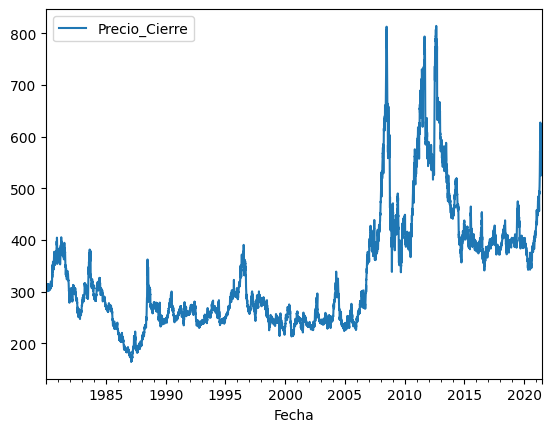

In [ ]:
datos_originales = pd.read_csv('/content/drive/MyDrive/prediccion_productos_agro/datos_maiz.csv')
datos_originales = datos_originales.rename(columns={'Date': 'Fecha', 'Last': 'Precio_Cierre'})
datos_originales["Fecha"] =  pd.to_datetime(datos_originales["Fecha"],format='%Y-%m-%d')
datos_originales.set_index("Fecha", inplace=True)
datos_originales = datos_originales.asfreq('D')
datos_originales.interpolate(inplace=True)
#datos_originales = datos_originales[datos_originales.index >="1980-02-21" ]
datos_originales.plot()

In [ ]:
def add_lags(df,pasos):
    target_map = df['Precio_Cierre'].to_dict()
    for i in range(pasos+1):
      df[f'retraso-{i}'] = (df.index - pd.Timedelta(f'{i} days')).map(target_map)
    df = df.drop(columns=["retraso-0"])
    df.dropna(inplace=True)
    return df

In [ ]:
def busqueda(datos_entrenamiento,datos_validacion):
  CARACTERISTICAS = [ "retraso-1", "retraso-2",	"retraso-3",	"retraso-4",	"retraso-5",	"retraso-6",	"retraso-7"]
  learning_rate = [0.01, 0.1, 0.2]
  max_depth = [2,3, 4, 5,6,7,8]
  subsample = [0.8, 0.9, 1.0]
  colsample_bytree = [0.7,0.8, 0.9, 1.0]

  errores_learning_rate = []
  errores_max_depth = {"i":{"j":[]}}
  errores = []

  X_train = datos_entrenamiento[CARACTERISTICAS]
  y_train =  datos_entrenamiento.Precio_Cierre

  X_test = datos_validacion[CARACTERISTICAS]
  y_test = datos_validacion.Precio_Cierre

  for i in learning_rate:
    for j in max_depth:
      for k in subsample:
        reg = xgb.XGBRegressor( base_score= None , booster= None ,
                              n_estimators= 1000 ,
                              early_stopping_rounds= 50 ,
                              subsample=k,
                              max_depth= j ,
                              learning_rate= i )


        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=0)
        y_predict = reg.predict(datos_validacion[CARACTERISTICAS])
        y_predict = pd.Series(y_predict)

        score = np.sqrt(mean_squared_error(y_predict,datos_validacion.Precio_Cierre))

        errores.append((i,j,k,score))


  indice, valor_minimo = min(enumerate(errores), key=lambda x: x[1][3])
  print("El número más pequeño en la posición 3 de las tuplas es:", valor_minimo[3])
  print("El índice de la tupla con el número más pequeño es:", indice)
  print( f"el learning rate es {errores[indice][0]} el max_depth es {errores[indice][1]} y el subsample es {errores[indice][2]}")

In [ ]:
PASOS =7
CARACTERISTICAS = [ "retraso-1", "retraso-2",	"retraso-3",	"retraso-4",	"retraso-5",	"retraso-6",	"retraso-7"]

# Modelado Componente 1

In [ ]:
componente_1 = componente_1.asfreq('D')
componente_1.interpolate(inplace=True)

In [ ]:
componente_1_values = componente_1.values
componente_1_values = componente_1_values.astype('float32')
componente_1_scaler = MinMaxScaler(feature_range=(-1, 1))
componente_1_values = componente_1_values.reshape(-1, 1)
componente_1_escalado =  pd.DataFrame(componente_1_scaler.fit_transform(componente_1_values), columns=componente_1.columns,index=componente_1.index)
componente_1_sup = add_lags(componente_1_escalado, PASOS)
componente_1_sup.head(5)

,Precio_Cierre,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
Fecha,,,,,,,,
1980-01-09,-0.545235,-0.545220,-0.545205,-0.545190,-0.545175,-0.545160,-0.545094,-0.545102
1980-01-10,-0.545073,-0.545235,-0.545220,-0.545205,-0.545190,-0.545175,-0.545160,-0.545094
1980-01-11,-0.544715,-0.545073,-0.545235,-0.545220,-0.545205,-0.545190,-0.545175,-0.545160
1980-01-12,-0.544569,-0.544715,-0.545073,-0.545235,-0.545220,-0.545205,-0.545190,-0.545175
1980-01-13,-0.544423,-0.544569,-0.544715,-0.545073,-0.545235,-0.545220,-0.545205,-0.545190


In [ ]:
total_datos=len(componente_1_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_c1 = componente_1_sup[:division_entrenamiento]
datos_validacion_c1 = componente_1_sup[division_entrenamiento:division_validacion]
datos_testeo_c1 = componente_1_sup[division_validacion:total_datos]

In [ ]:
componente_1_sup.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15148 entries, 1980-01-09 to 2021-06-29
Freq: D
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Precio_Cierre  15148 non-null  float32
 1   retraso-1      15148 non-null  float64
 2   retraso-2      15148 non-null  float64
 3   retraso-3      15148 non-null  float64
 4   retraso-4      15148 non-null  float64
 5   retraso-5      15148 non-null  float64
 6   retraso-6      15148 non-null  float64
 7   retraso-7      15148 non-null  float64
dtypes: float32(1), float64(7)
memory usage: 1005.9 KB


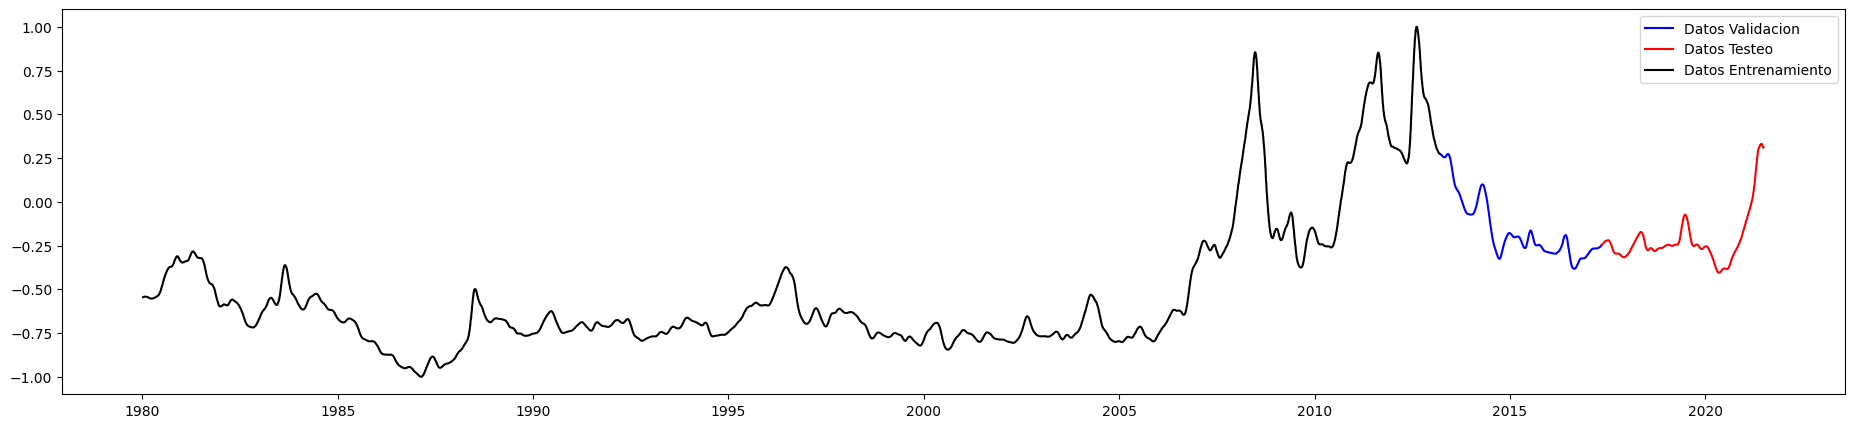

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_validacion_c1.index,datos_validacion_c1.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_c1.index,datos_testeo_c1.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_entrenamiento_c1.index,datos_entrenamiento_c1.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
busqueda(datos_entrenamiento_c1,datos_validacion_c1)

El número más pequeño en la posición 3 de las tuplas es: 0.00928947
El índice de la tupla con el número más pequeño es: 0
el learning rate es 0.01 el max_depth es 2 y el subsample es 0.8


In [ ]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 365 , gap= 1 )
componente_1_sup =componente_1_sup.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(componente_1_sup[:division_validacion]) :
    train = componente_1_sup.iloc[train_idx]
    test = componente_1_sup.iloc[val_idx]

    OBJETIVO = 'Precio_Cierre'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           max_depth= 2 ,
                           learning_rate= 0.01,
                            subsample= 0.8
                            )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=0)

    validacion_componente_1 = reg.predict(X_test)
    validacion_componente_1 = pd.Series(validacion_componente_1)
    preds.append(validacion_componente_1)
    score = np.sqrt(mean_squared_error(validacion_componente_1,y_test))
    mae = mean_absolute_error(validacion_componente_1,y_test)
    mape = mean_absolute_percentage_error(validacion_componente_1,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)
validacion_componente_1 = reg.predict(datos_validacion_c1[CARACTERISTICAS])
prediccion_componente_1 = reg.predict(datos_testeo_c1[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

Puntuación entre pliegues 0.003451550379395485 
Puntuaciones plegar: [0.004779787, 0.0028016253, 0.0027732388] 
Error Absoluto medio entre pliegues 0.0026845496613532305
porcentaje de error absoluto medio entre pliegues 0.042315635830163956


In [ ]:
score = np.sqrt(mean_squared_error(datos_testeo_c1[OBJETIVO],prediccion_componente_1))

print(f"La raiz del error Cuadratico medio del modelo es {score}")

La raiz del error Cuadratico medio del modelo es 0.0040825894102454185


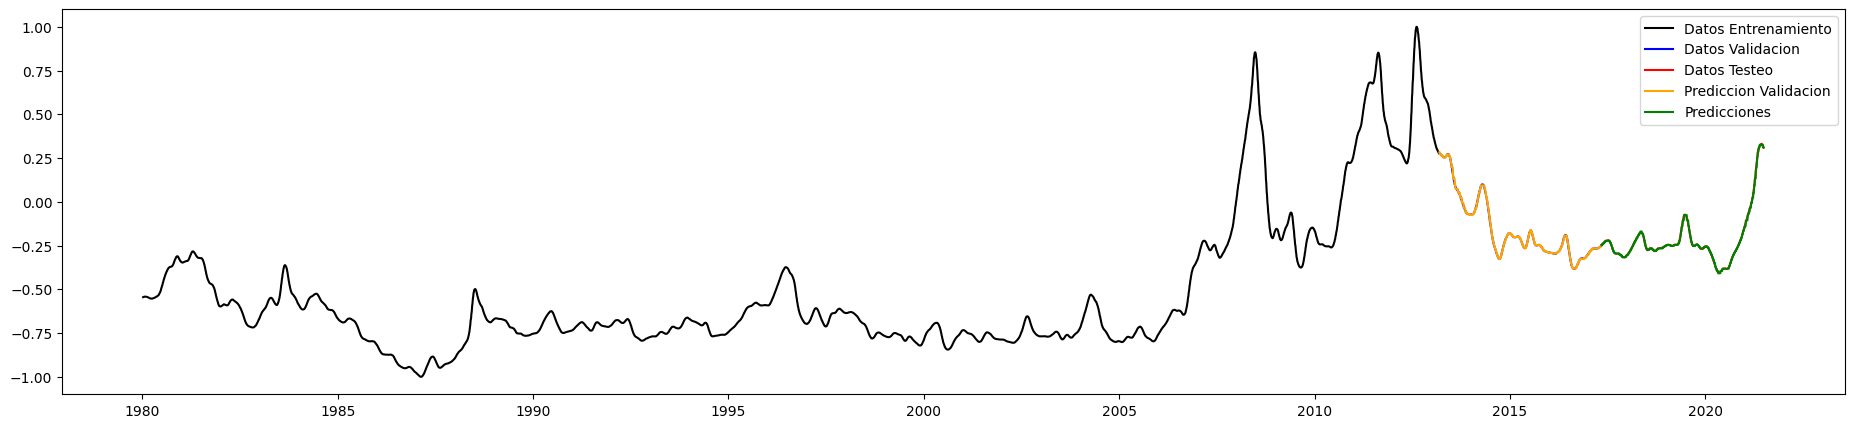

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_c1.index,datos_entrenamiento_c1.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_c1.index,datos_validacion_c1.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_c1.index,datos_testeo_c1.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion_c1.index,validacion_componente_1,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo_c1.index,prediccion_componente_1,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
validacion_componente_1 = componente_1_scaler.inverse_transform(validacion_componente_1.reshape(-1, 1))
prediccion_componente_1 = componente_1_scaler.inverse_transform(prediccion_componente_1.reshape(-1, 1))

# Modelamos Componente 2

In [ ]:
componente_2 = componente_2.asfreq('D')
componente_2.interpolate(inplace=True)

In [ ]:
componente_2_values = componente_2.values
componente_2_values = componente_2_values.astype('float32')
componente_2_scaler = MinMaxScaler(feature_range=(-1, 1))
componente_2_values = componente_2_values.reshape(-1, 1)
componente_2_escalado =  pd.DataFrame(componente_2_scaler.fit_transform(componente_2_values), columns=componente_2.columns,index=componente_2.index)
componente_2_sup = add_lags(componente_2_escalado, PASOS)
componente_2_sup.head(5)

,Precio_Cierre,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
Fecha,,,,,,,,
1980-01-09,-0.265923,-0.265032,-0.264140,-0.263249,-0.262358,-0.261467,-0.256715,-0.250903
1980-01-10,-0.266961,-0.265923,-0.265032,-0.264140,-0.263249,-0.262358,-0.261467,-0.256715
1980-01-11,-0.264509,-0.266961,-0.265923,-0.265032,-0.264140,-0.263249,-0.262358,-0.261467
1980-01-12,-0.263497,-0.264509,-0.266961,-0.265923,-0.265032,-0.264140,-0.263249,-0.262358
1980-01-13,-0.262485,-0.263497,-0.264509,-0.266961,-0.265923,-0.265032,-0.264140,-0.263249


In [ ]:
total_datos=len(componente_2_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_c2 = componente_2_sup[:division_entrenamiento]
datos_validacion_c2 = componente_2_sup[division_entrenamiento:division_validacion]
datos_testeo_c2 = componente_2_sup[division_validacion:total_datos]

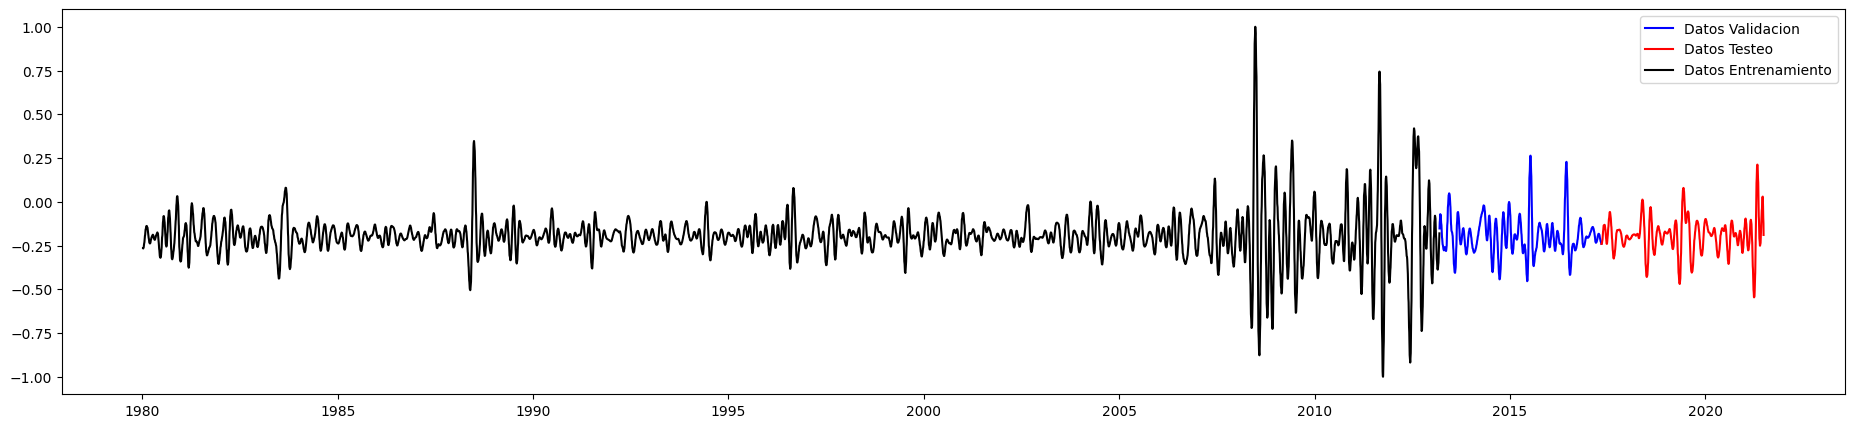

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_validacion_c2.index,datos_validacion_c2.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_c2.index,datos_testeo_c2.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_entrenamiento_c2.index,datos_entrenamiento_c2.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
busqueda(datos_entrenamiento_c2,datos_validacion_c2)

El número más pequeño en la posición 3 de las tuplas es: 0.0063722017
El índice de la tupla con el número más pequeño es: 29
el learning rate es 0.1 el max_depth es 4 y el subsample es 1.0


In [ ]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 365 , gap= 1 )
componente_2_sup =componente_2_sup.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(componente_2_sup[:division_validacion]) :
    train = componente_2_sup.iloc[train_idx]
    test = componente_2_sup.iloc[val_idx]

    OBJETIVO = 'Precio_Cierre'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           max_depth= 4 ,
                           learning_rate= 0.1,
                            subsample= 1.0
                            )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=0)

    validacion_componente_2 = reg.predict(X_test)
    validacion_componente_2 = pd.Series(validacion_componente_2)
    preds.append(validacion_componente_2)
    score = np.sqrt(mean_squared_error(validacion_componente_2,y_test))
    mae = mean_absolute_error(validacion_componente_2,y_test)
    mape = mean_absolute_percentage_error(validacion_componente_2,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)
validacion_componente_2 = reg.predict(datos_validacion_c2[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

Puntuación entre pliegues 0.006906909868121147 
Puntuaciones plegar: [0.0054465453, 0.007647387, 0.0076267966] 
Error Absoluto medio entre pliegues 0.00438819220289588
porcentaje de error absoluto medio entre pliegues 0.10823880881071091


In [ ]:
prediccion_componente_2 = reg.predict(datos_testeo_c2[CARACTERISTICAS])
score = np.sqrt(mean_squared_error(datos_testeo_c2[OBJETIVO],prediccion_componente_2))

print(f"La raiz del error Cuadratico medio del modelo es {score}")

La raiz del error Cuadratico medio del modelo es 0.006362796761095524


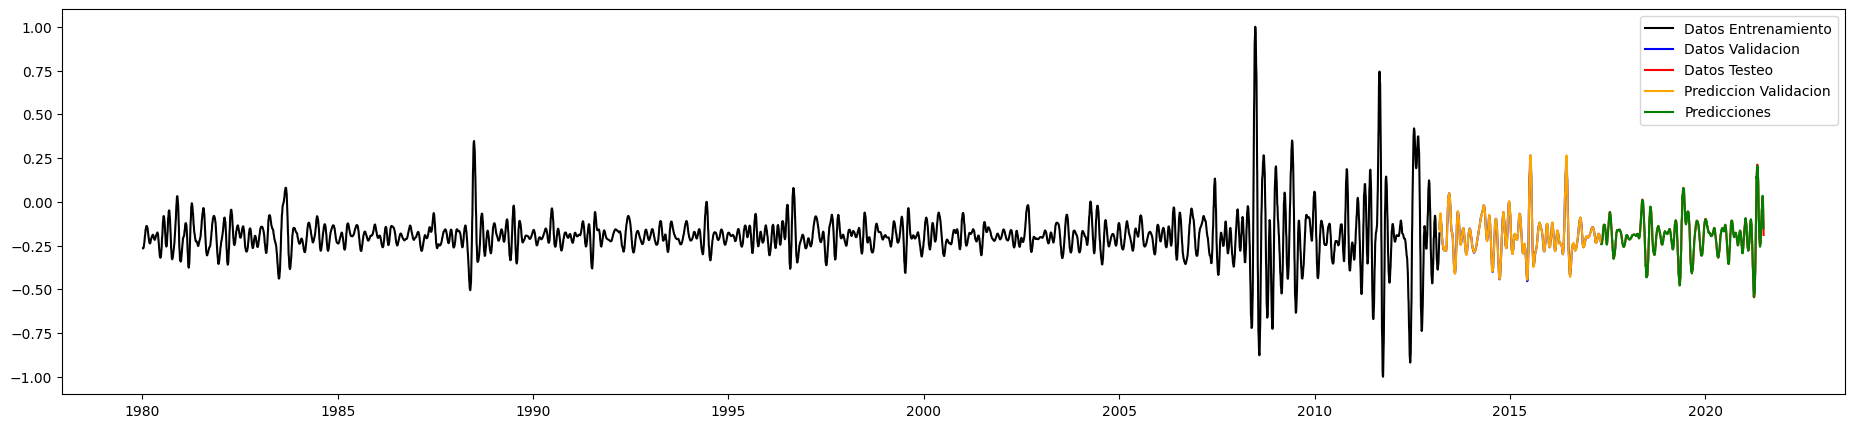

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_c2.index,datos_entrenamiento_c2.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_c2.index,datos_validacion_c2.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_c2.index,datos_testeo_c2.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion_c2.index,validacion_componente_2,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo_c2.index,prediccion_componente_2,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
validacion_componente_2 = componente_2_scaler.inverse_transform(validacion_componente_2.reshape(-1, 1))
prediccion_componente_2 = componente_2_scaler.inverse_transform(prediccion_componente_2.reshape(-1, 1))

# Modelamos Componente 3

In [ ]:
componente_3 = componente_3.asfreq('D')
componente_3.interpolate(inplace=True)

In [ ]:
componente_3_values = componente_3.values
componente_3_values = componente_3_values.astype('float32')
componente_3_scaler = MinMaxScaler(feature_range=(-1, 1))
componente_3_values = componente_3_values.reshape(-1, 1)
componente_3_escalado =  pd.DataFrame(componente_3_scaler.fit_transform(componente_3_values), columns=componente_3.columns,index=componente_3.index)
componente_3_sup = add_lags(componente_3_escalado, PASOS)
componente_3_sup.tail(5)

,Precio_Cierre,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
Fecha,,,,,,,,
2021-06-25,-0.810669,-0.660150,-0.471149,-0.250276,-0.020395,0.054050,0.128494,0.202939
2021-06-26,-0.843441,-0.810669,-0.660150,-0.471149,-0.250276,-0.020395,0.054050,0.128494
2021-06-27,-0.876213,-0.843441,-0.810669,-0.660150,-0.471149,-0.250276,-0.020395,0.054050
2021-06-28,-0.908985,-0.876213,-0.843441,-0.810669,-0.660150,-0.471149,-0.250276,-0.020395
2021-06-29,-1.000000,-0.908985,-0.876213,-0.843441,-0.810669,-0.660150,-0.471149,-0.250276


In [ ]:
total_datos=len(componente_3_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_c3 = componente_3_sup[:division_entrenamiento]
datos_validacion_c3 = componente_3_sup[division_entrenamiento:division_validacion]
datos_testeo_c3 = componente_3_sup[division_validacion:total_datos]

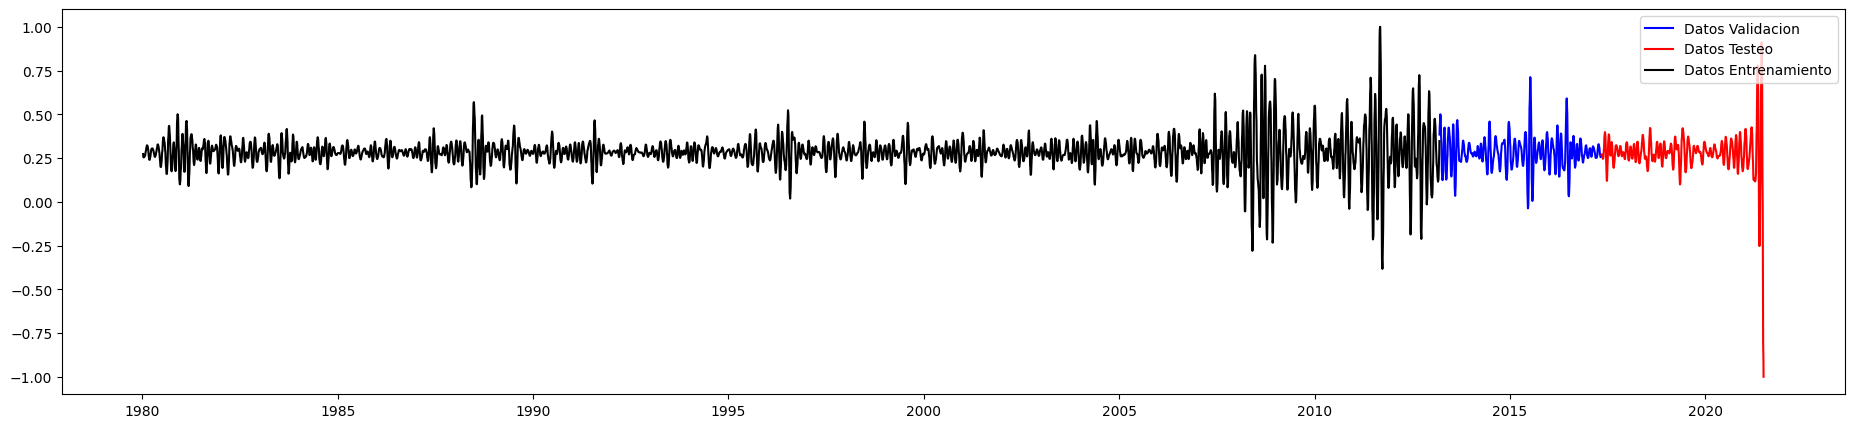

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_validacion_c3.index,datos_validacion_c3.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_c3.index,datos_testeo_c3.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_entrenamiento_c3.index,datos_entrenamiento_c3.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
busqueda(datos_entrenamiento_c3,datos_validacion_c3)

El número más pequeño en la posición 3 de las tuplas es: 0.009150594
El índice de la tupla con el número más pequeño es: 50
el learning rate es 0.2 el max_depth es 4 y el subsample es 1.0


In [ ]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 365 , gap= 1 )
componente_3_sup =componente_3_sup.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(componente_3_sup[:division_validacion]) :
    train = componente_3_sup.iloc[train_idx]
    test = componente_3_sup.iloc[val_idx]

    OBJETIVO = 'Precio_Cierre'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           max_depth= 4 ,
                           learning_rate= 0.2,
                            subsample= 1.0
                            )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=0)

    validacion_componente_3 = reg.predict(X_test)
    validacion_componente_3 = pd.Series(validacion_componente_3)
    preds.append(validacion_componente_3)
    score = np.sqrt(mean_squared_error(validacion_componente_3,y_test))
    mae = mean_absolute_error(validacion_componente_3,y_test)
    mape = mean_absolute_percentage_error(validacion_componente_3,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)
validacion_componente_3 = reg.predict(datos_validacion_c3[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

Puntuación entre pliegues 0.008346143178641796 
Puntuaciones plegar: [0.005095483, 0.013708455, 0.0062344926] 
Error Absoluto medio entre pliegues 0.005319240037351847
porcentaje de error absoluto medio entre pliegues 0.034490156918764114


In [ ]:
prediccion_componente_3 = reg.predict(datos_testeo_c3[CARACTERISTICAS])
score = np.sqrt(mean_squared_error(datos_testeo_c3[OBJETIVO],prediccion_componente_3))

print(f"La raiz del error Cuadratico medio del modelo es {score}")

La raiz del error Cuadratico medio del modelo es 0.04005076363682747


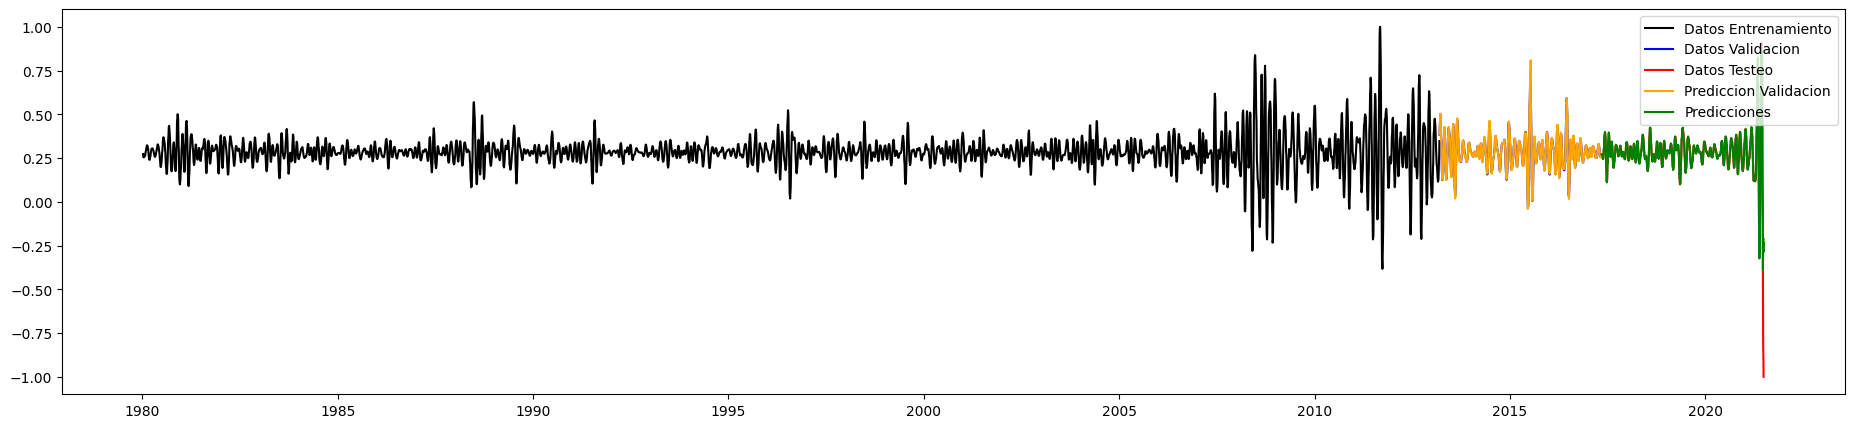

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_c3.index,datos_entrenamiento_c3.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_c3.index,datos_validacion_c3.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_c3.index,datos_testeo_c3.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion_c3.index,validacion_componente_3,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo_c3.index,prediccion_componente_3,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
validacion_componente_3 = componente_3_scaler.inverse_transform(validacion_componente_3.reshape(-1, 1))
prediccion_componente_3 = componente_3_scaler.inverse_transform(prediccion_componente_3.reshape(-1, 1))

# Modelamos Componente 4

In [ ]:
componente_4 = componente_4.asfreq('D')
componente_4.interpolate(inplace=True)

In [ ]:
componente_4_values = componente_4.values
componente_4_values = componente_4_values.astype('float32')
componente_4_scaler = MinMaxScaler(feature_range=(-1, 1))
componente_4_values = componente_4_values.reshape(-1, 1)
componente_4_escalado =  pd.DataFrame(componente_4_scaler.fit_transform(componente_4_values), columns=componente_4.columns,index=componente_4.index)
componente_4_sup = add_lags(componente_4_escalado, PASOS)
componente_4_sup.head(5)

,Precio_Cierre,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
Fecha,,,,,,,,
1980-01-09,-0.033787,-0.026499,-0.019211,-0.011922,-0.004634,0.002655,0.035792,0.064877
1980-01-10,-0.061464,-0.033787,-0.026499,-0.019211,-0.011922,-0.004634,0.002655,0.035792
1980-01-11,-0.078241,-0.061464,-0.033787,-0.026499,-0.019211,-0.011922,-0.004634,0.002655
1980-01-12,-0.082754,-0.078241,-0.061464,-0.033787,-0.026499,-0.019211,-0.011922,-0.004634
1980-01-13,-0.087267,-0.082754,-0.078241,-0.061464,-0.033787,-0.026499,-0.019211,-0.011922


In [ ]:
total_datos=len(componente_4_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_c4 = componente_4_sup[:division_entrenamiento]
datos_validacion_c4 = componente_4_sup[division_entrenamiento:division_validacion]
datos_testeo_c4 = componente_4_sup[division_validacion:total_datos]

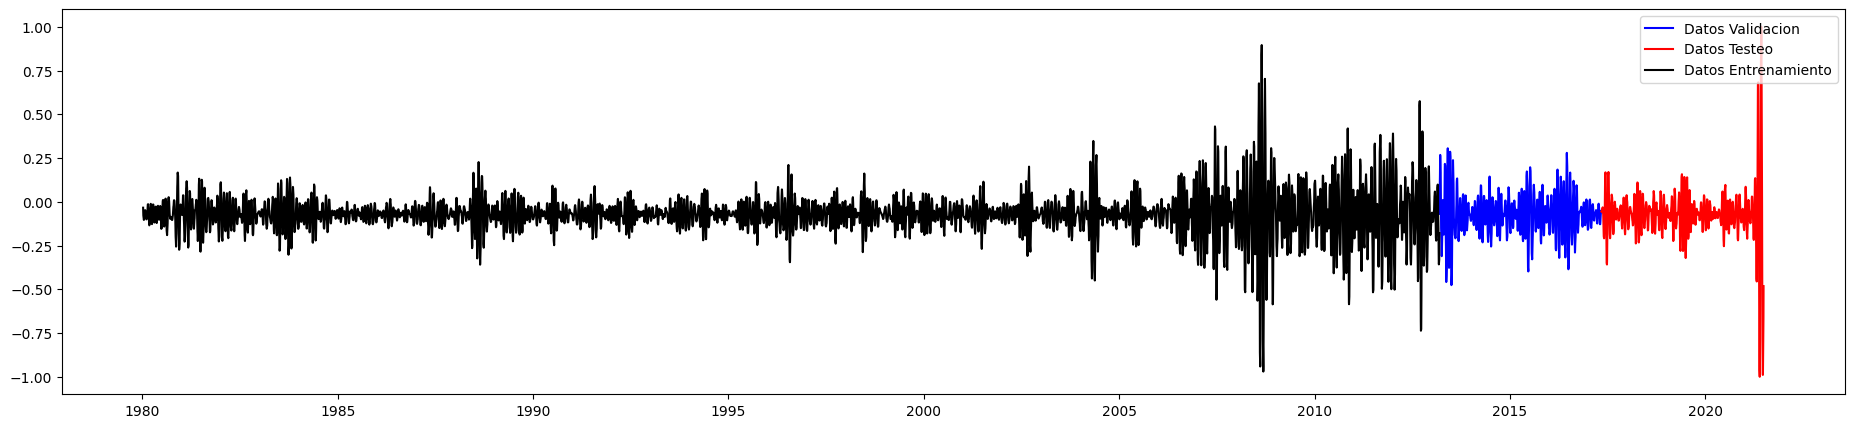

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_validacion_c4.index,datos_validacion_c4.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_c4.index,datos_testeo_c4.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_entrenamiento_c4.index,datos_entrenamiento_c4.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
busqueda(datos_entrenamiento_c4,datos_validacion_c4)

El número más pequeño en la posición 3 de las tuplas es: 0.013954479
El índice de la tupla con el número más pequeño es: 28
el learning rate es 0.1 el max_depth es 4 y el subsample es 0.9


In [ ]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 365 , gap= 1 )
componente_4_sup =componente_4_sup.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(componente_4_sup[:division_validacion]) :
    train = componente_4_sup.iloc[train_idx]
    test = componente_4_sup.iloc[val_idx]

    OBJETIVO = 'Precio_Cierre'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           max_depth= 4 ,
                           learning_rate= 0.1,
                            subsample= 0.9
                            )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=0)

    validacion_componente_4 = reg.predict(X_test)
    validacion_componente_4 = pd.Series(validacion_componente_4)
    preds.append(validacion_componente_4)
    score = np.sqrt(mean_squared_error(validacion_componente_4,y_test))
    mae = mean_absolute_error(validacion_componente_4,y_test)
    mape = mean_absolute_percentage_error(validacion_componente_4,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)
validacion_componente_4 = reg.predict(datos_validacion_c4[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

Puntuación entre pliegues 0.01116527896374464 
Puntuaciones plegar: [0.008828313, 0.013589681, 0.011077841] 
Error Absoluto medio entre pliegues 0.00848778523504734
porcentaje de error absoluto medio entre pliegues 0.39170774817466736


In [ ]:
prediccion_componente_4 = reg.predict(datos_testeo_c4[CARACTERISTICAS])
score = np.sqrt(mean_squared_error(datos_testeo_c4[OBJETIVO],prediccion_componente_4))

print(f"La raiz del error Cuadratico medio del modelo es {score}")

La raiz del error Cuadratico medio del modelo es 0.040620289742946625


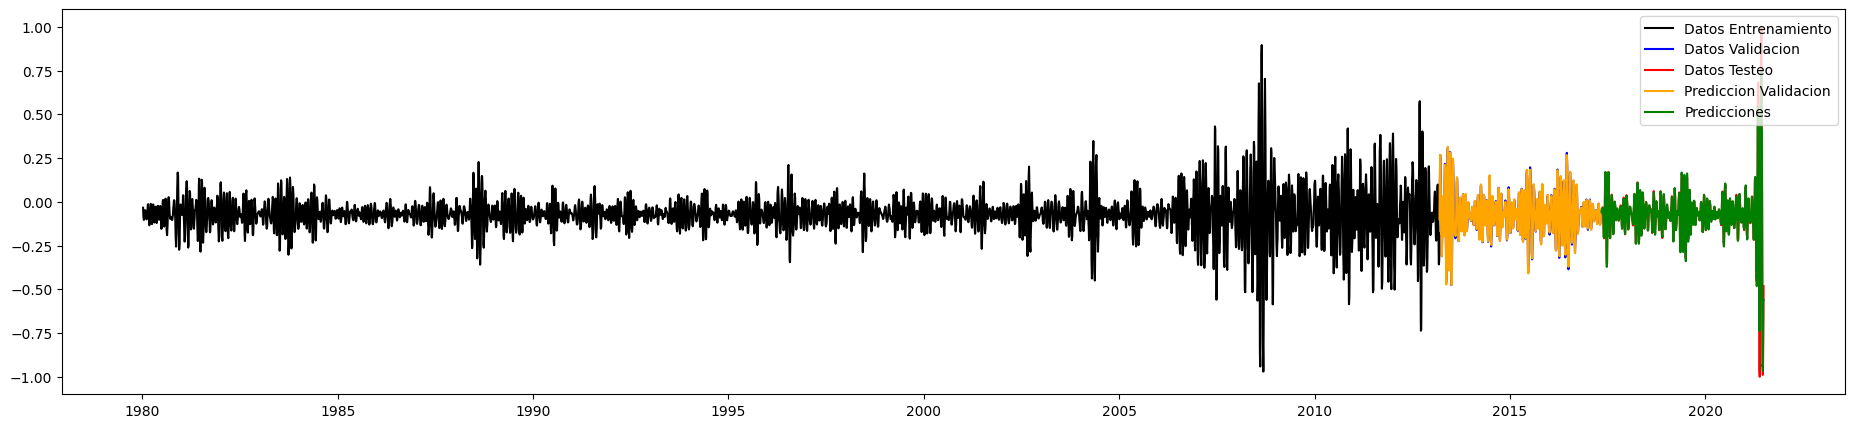

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_c4.index,datos_entrenamiento_c4.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_c4.index,datos_validacion_c4.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_c4.index,datos_testeo_c4.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion_c4.index,validacion_componente_4,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo_c4.index,prediccion_componente_4,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
validacion_componente_4 = componente_4_scaler.inverse_transform(validacion_componente_4.reshape(-1, 1))
prediccion_componente_4 = componente_4_scaler.inverse_transform(prediccion_componente_4.reshape(-1, 1))

# Ensemble

In [ ]:
total_datos=len(datos_originales.Precio_Cierre)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento = datos_originales[:division_entrenamiento]
datos_validacion_originales = datos_originales[division_entrenamiento:division_validacion]
datos_testeo_originales = datos_originales[division_validacion:total_datos]

Metricas Validacion

In [ ]:
validacion = validacion_componente_1 + validacion_componente_2 + validacion_componente_3 + validacion_componente_4
recm_validacion = np.sqrt(mean_squared_error(validacion,datos_validacion_originales.Precio_Cierre[1:]))
eam_validacion = mean_absolute_error( validacion,datos_validacion_originales.Precio_Cierre[1:])
EPAM_validacion = mean_absolute_percentage_error( validacion,datos_validacion_originales.Precio_Cierre[1:])


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm_validacion} ' )
print ( f'el error absoluto medio del modelo es: {eam_validacion} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM_validacion}")

La raiz del error cuadratico medio del modelo es: 4.704430365535355 
el error absoluto medio del modelo es: 3.584093376908834 
Error porcentual absoluto medio del modelo es: 0.00825655775212453


Metricas Testeo

In [ ]:
prediccion = prediccion_componente_1 + prediccion_componente_2 + prediccion_componente_3 + prediccion_componente_4

In [ ]:
recm = np.sqrt(mean_squared_error( prediccion,datos_testeo_originales.Precio_Cierre))
eam = mean_absolute_error( prediccion,datos_testeo_originales.Precio_Cierre)
EPAM = mean_absolute_percentage_error(prediccion,datos_testeo_originales.Precio_Cierre)


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm} ' )
print ( f'el error absoluto medio del modelo es: {eam} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM}")

La raiz del error cuadratico medio del modelo es: 4.7696592126948065 
el error absoluto medio del modelo es: 3.1050587086270753 
Error porcentual absoluto medio del modelo es: 0.007273344678177224


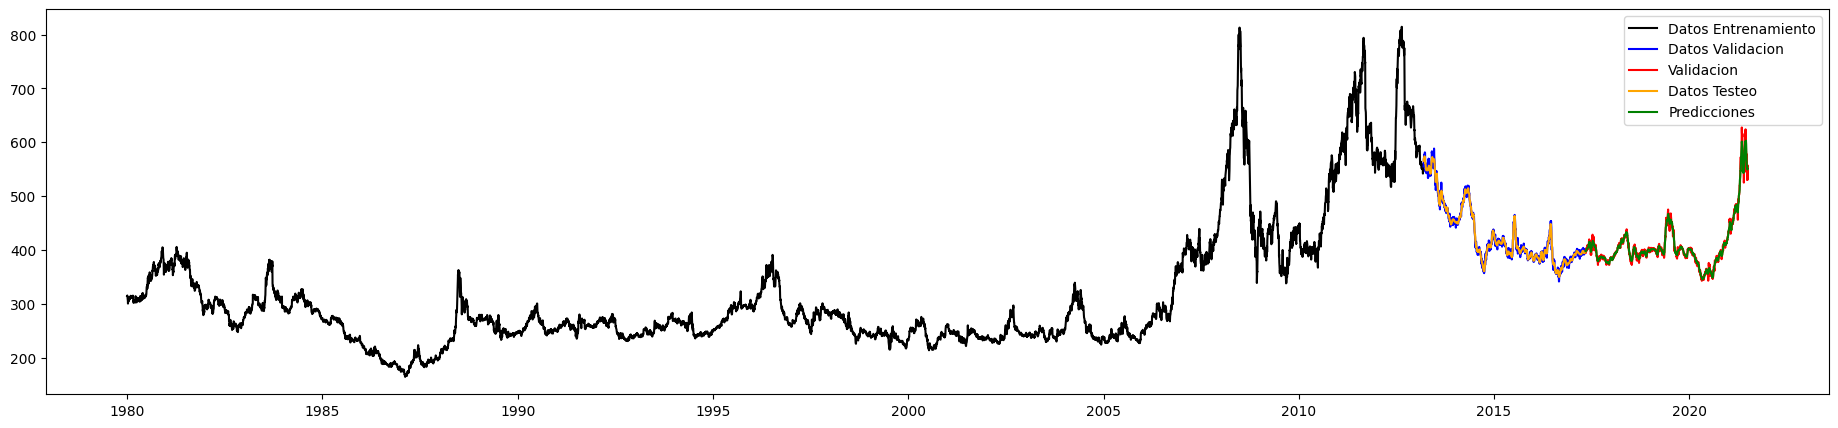

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_originales.index,datos_validacion_originales.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_originales.index,datos_testeo_originales.Precio_Cierre,color='red',label = 'Validacion')
ax.plot(datos_validacion_originales[1:].index,validacion,color='orange',label = 'Datos Testeo')
ax.plot(datos_testeo_originales.index,prediccion,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

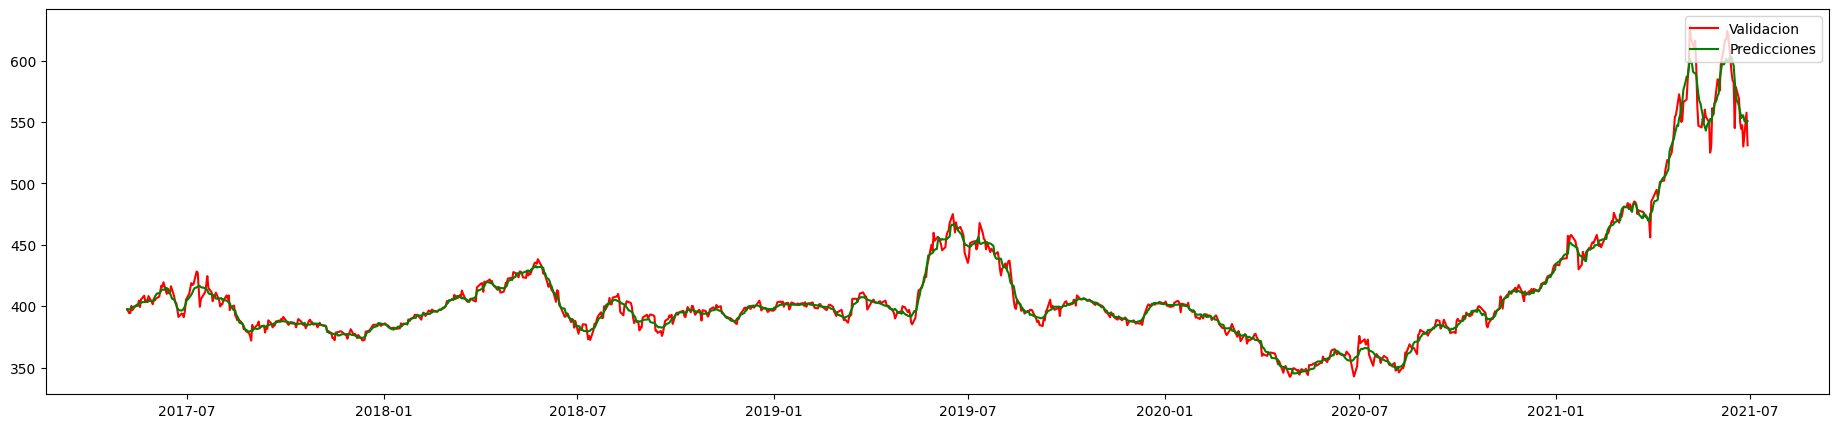

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_testeo_originales.index,datos_testeo_originales.Precio_Cierre,color='red',label = 'Validacion')
ax.plot(datos_testeo_originales.index,prediccion,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
validacion =pd.DataFrame(validacion,index=datos_validacion_originales.index[1:],columns=['Precio_Cierre'])
testeo = pd.DataFrame(prediccion,index=datos_testeo_originales.index,columns=['Precio_Cierre'])

In [ ]:
validacion.to_csv("/content/drive/MyDrive/prediccion_productos_agro/Predicciones/SSA/validacion_xgboost.csv",index=True)
testeo.to_csv("/content/drive/MyDrive/prediccion_productos_agro/Predicciones/SSA/testeo_xgboost.csv",index=True)